### ResNet50

To 50-warstwowa sieć konwolucyjna należąca do rodzimy sieci ResNet która składa sie z:
- 48 warstw kownolucyjnych
- 1 warstwa poolingowa
- 1 warstwa fully connected

ResNet50 składa sie z 4 bloków residual które grupuja kilka warstw konwolucyjnych  


In [1]:
import pickle
from tensorflow.keras.utils import to_categorical
import pandas as pd
import tensorflow as tf

from keras.callbacks import Callback, EarlyStopping ,ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D
from keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.xception import Xception
from keras.preprocessing import image
from livelossplot import PlotLossesKeras 
import cv2
import numpy as np
np.random.seed(0)




### Wczytywanie danych 

In [2]:

train_dir = r"..\input\train"
test_dir = r"..\input\test"

### Tworzenie generatora danych 

In [3]:
datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(48,48),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(48,48),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")


Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.
Number of classes: 7


### Wykrywanie liczby klas

In [4]:
print(f"Train class indices: {train_generator.class_indices}")
print(f"Validation class indices: {validation_generator.class_indices}")

Train class indices: {'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}
Validation class indices: {'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}


In [5]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

### Proces odmrazania warstw konwolucyjnych

- Najpierw zamrazamy wszystie warstwy modelu 
- Nastepnie okreslamy ilosc warstw które maja byc trenowane
- Potem odmrazamy warstwy które maja byc trenowane

In [6]:
for layer in base_model.layers[1:]:
    layer.trainable = False

num_layers_to_unfreeze = 3  # liczba warstw do odmrożenia

for layer in base_model.layers[-num_layers_to_unfreeze:]:
    layer.trainable = True


In [7]:
model = Sequential([
    base_model,
    Flatten(), 
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(7 , activation='softmax')
])

optimizer = Adam(0.001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

### Konfiguracja szkolenia

In [8]:
callbacks = [
    PlotLossesKeras(),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    
    ModelCheckpoint(filepath= r'..\models\emotion_model_InceptionV3_model_{epoch:02d}_{val_loss:.2f}.keras', 
                    monitor='val_loss', save_best_only=True, mode='min' , verbose=1),
    ReduceLROnPlateau( monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='auto', min_lr=1e-6 ) 
]


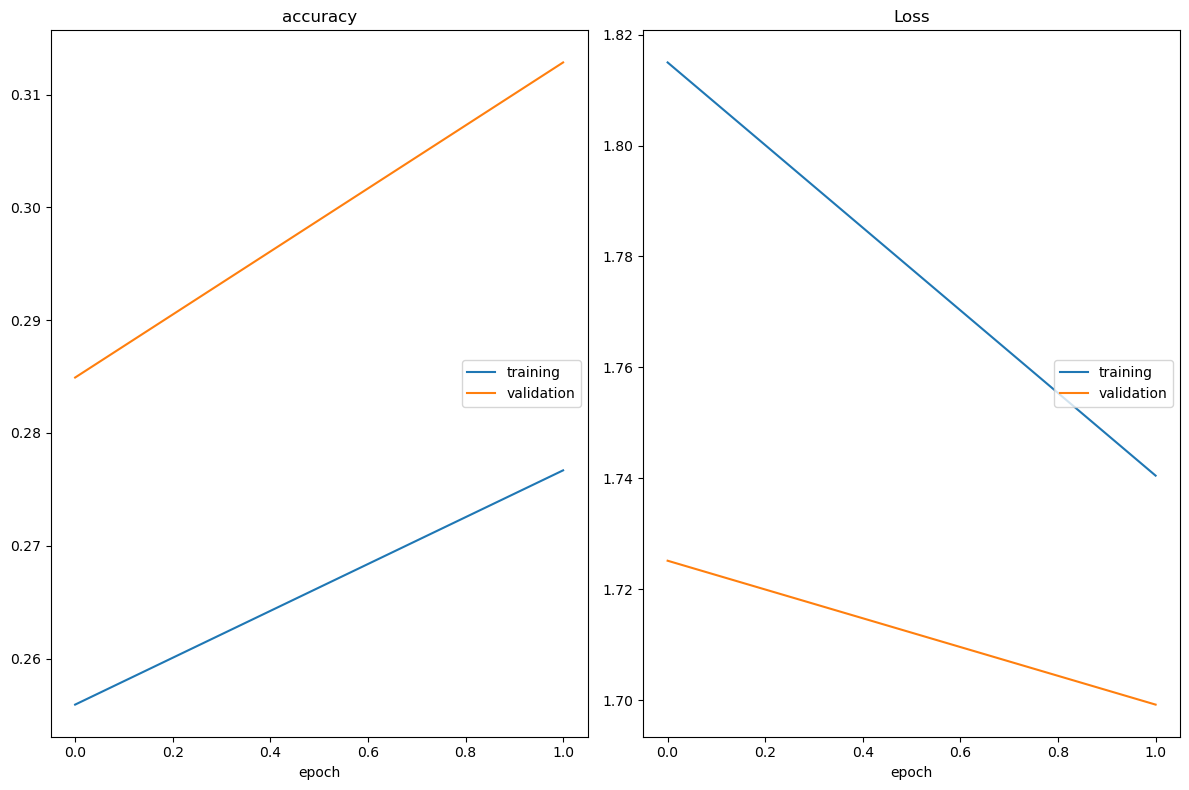

accuracy
	training         	 (min:    0.256, max:    0.277, cur:    0.277)
	validation       	 (min:    0.285, max:    0.313, cur:    0.313)
Loss
	training         	 (min:    1.740, max:    1.815, cur:    1.740)
	validation       	 (min:    1.699, max:    1.725, cur:    1.699)

Epoch 2: val_loss improved from 1.72515 to 1.69921, saving model to ..\models\emotion_model_InceptionV3_model_02_1.70.keras
718/718 ━━━━━━━━━━━━━━━━━━━━ 283s 394ms/step - accuracy: 0.2762 - loss: 1.7510 - val_accuracy: 0.3128 - val_loss: 1.6992 - learning_rate: 0.0010
Epoch 3/20
380/718 ━━━━━━━━━━━━━━━━━━━━ 2:00 357ms/step - accuracy: 0.2943 - loss: 1.7250

In [ ]:

with tf.device('/GPU:0'):
    history = model.fit(
        train_generator,
        epochs=20,
        callbacks=callbacks,
        validation_data=validation_generator
    )

### Podsumowanie i Wnioski

